In [2]:
%run '/mnt/berger2/equipes/IGE/meom/workdir/berger2/fonctions/meom_fonctions/fonctions.ipynb'

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.netcdf as netcdf
import qgutils as qg
from matplotlib import ticker, cm
plt.ion()

In [3]:
#paramètres gravés dans le marbre pour le stage

Delta = 10000                               #grid spacing
f0 = 9.37456E-05                           #paramètre de Coriolis
dh = np.array([350,750,2900])              #hauteurs des couches océaniques
dh_b = 0.5*(dh[1:]+dh[:-1])
g_prime = np.array([2.5E-02,1.25E-02])     #gravités réduites aux interfaces
Beta = 1.75360E-11
delta_ek = 5                               #ocean bottom Ekman thickness 
nu4 = 2E09                                 #bi-harmonic viscosity
Ht = np.sum(dh)
Ht_b = np.sum(dh_b)
toc = np.array([1.31693E+01,1.81693E+01,2.41693E+01])
bf = delta_ek*f0/(2*dh[-1])

#fréquences Brunt-vaisala

N_12 = g_prime[0]/((dh[0]+dh[1])/2)
N_23 = g_prime[1]/((dh[1]+dh[2])/2)
N2 = np.array([N_12,N_23])

In [4]:
dir0  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_6tdiff_dt10/'

file0 = 'ocpo.nc'
file1 = 'ocsst.nc'

In [5]:
#get files psi
pfile = dir0 + file0


f = netcdf.netcdf_file(dir0 + file0,'r')

In [6]:
#size

si_t = f.variables['time'][:].copy().size

p = qg.read_qgcm(pfile, 0, var='p', rescale = 1/f0, interp = True, subtract_bc = False )
nz,ny,nx = p.shape

In [7]:
%%time
# compute means 


p_me = np.zeros((nz,ny,nx))
p_me_avc = np.zeros((nz,ny,nx))


n_me = 1

for it in range(0,si_t):
  
    p = qg.read_qgcm(pfile, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    p_avc = qg.read_qgcm(pfile, it, var='p', rescale = 1/f0, interp = True, subtract_bc = False)
    
    p_me += (p - p_me)/n_me
    p_me_avc += (p_avc - p_me_avc)/n_me
    
    n_me += 1

CPU times: user 31.8 s, sys: 2.46 s, total: 34.3 s
Wall time: 4min 59s


In [8]:
#other mean quantities derived from the mean streamfunction

u_me,v_me = qg.comp_vel(p_me, Delta=Delta, loc='center')
u_me_avc, v_me_avc = qg.comp_vel(p_me_avc, Delta=Delta, loc='center')

b_me = qg.p2b(p_me, dh, f0)
b_me_avc = qg.p2b(p_me_avc, dh, f0)

In [9]:
#necessary variables

p = qg.read_qgcm(pfile, 100, var='p', rescale = 1/f0, interp = True, subtract_bc = True)

u,v = qg.comp_vel(p, Delta=Delta, loc='center')
    
b = qg.p2b(p, dh, f0)
  
u_p = u - u_me
v_p = v - v_me
b_p = b - b_me
p_p = p - p_me
        
u_p_use = reduce_z_dim(u_p, dh)
v_p_use = reduce_z_dim(v_p, dh)
p_p_use = reduce_z_dim(p_p, dh)

In [16]:
#MPE to EPE, MPE perspective
#ref
rec_pe = -(b_me/N2[:,None,None])*qg.jacobian(p_p_use,b_p,Delta)

#uninterp b with diff
dbdx = np.diff(b,1,2)/Delta
dbdy = np.diff(b,1,1)/Delta

#uninterp u and v with average of
u_unx = 0.5*(u_p_use[:,:,1:] + u_p_use[:,:,:-1])
v_uny = 0.5*(v_p_use[:,1:,:] + v_p_use[:,:-1,:])

#compute the expression sparately with padding to obtain (513,512)ish arrays
u_dbdx = np.pad(u_unx*dbdx,((0,0),(0,0),(1,1)))
v_dbdy = np.pad(v_uny*dbdy,((0,0),(1,1),(0,0)))

#compute the expression
mpe2epe = -(b_me/N2[:,None,None])*0.5*(u_dbdx[:,:,1:] + u_dbdx[:,:,:-1] 
                                     + v_dbdy[:,1:,:] + v_dbdy[:,:-1,:])


print(mpe2epe.shape)


(2, 512, 512)


In [16]:
#MPE to EPE, MPE perspective

tran = 365*86400/(0.01**2)
print('Mean value for rel cycle should be 85, it is 12 for the (attempted) expression with physical meaning')
print('')
print('bc substracted  :',qg.integral(mpe2epe,dh,Delta,average=True)*tran)
print('reference value :',qg.integral(rec_pe,dh,Delta,average=True)*tran)

Mean value for rel cycle should be 85, it is 12 for the (attempted) expression with physical meaning

bc substracted  : -193.9795845106916
reference value : -194.1357289903661


In [12]:
#MPE to EPE, EPE perspective

#uninterp b_me with diff
dbdx_me = np.diff(b_me,1,2)/Delta
dbdy_me = np.diff(b_me,1,1)/Delta

#compute the expression sparately with padding to obtain (513,512)ish arrays
dbdx_pad = np.pad(dbdx_me,((0,0),(0,0),(1,1)))
dbdy_pad = np.pad(dbdy_me,((0,0),(1,1),(0,0)))

#compute the expression
epe2mpe = (0.5/N2[:,None,None])*((dbdx_pad[:,:,1:] + dbdx_pad[:,:,:-1])*u_p_use*b_p
                                 + (dbdy_pad[:,:-1,:]+dbdy_pad[:,1:,:])*v_p_use*b_p)

print(epe2mpe.shape)

(2, 512, 512)


In [21]:
#MPE to EPE, EPE perspective

print('Mean value for rel cycle should be 85, it is 12 for the (attempted) expression with physical meaning')
print('')
print('abs, bc substracted  :',qg.integral(epe2mpe,dh,Delta,average=True)*tran)
print('abs, reference value :',qg.integral(rec_pe,dh,Delta,average=True)*tran)


Mean value for rel cycle should be 85, it is 12 for the (attempted) expression with physical meaning

abs, bc substracted  : -194.94965860051133
abs, reference value : -194.1357289903661


In [13]:
#MKE to EKE, MKE perspective

#ref
rec_ke = p_me*qg.jacobian(p_p, qg.laplacian(p_p,Delta),Delta)

#uninterp u_me and v_me with diff
dudx_me = np.diff(u_me,1,2)/Delta
dudy_me = np.diff(u_me,1,1)/Delta
dvdx_me = np.diff(v_me,1,2)/Delta
dvdy_me = np.diff(v_me,1,1)/Delta

#compute the expression sparately with padding to obtain (513,512)ish arrays
dudx_pad = np.pad(dudx_me,((0,0),(0,0),(1,1)))
dudy_pad = np.pad(dudy_me,((0,0),(1,1),(0,0)))
dvdx_pad = np.pad(dvdx_me,((0,0),(0,0),(1,1)))
dvdy_pad = np.pad(dvdy_me,((0,0),(1,1),(0,0)))

mke2eke = 0.5*((dudx_pad[:,:,1:]+dudx_pad[:,:,:-1])*u_p**2 
          +(dudy_pad[:,1:,:]+dudy_pad[:,:-1,:])*u_p*v_p
          +(dvdx_pad[:,:,1:]+dvdx_pad[:,:,:-1])*u_p*v_p
          +(dvdy_pad[:,1:,:]+dvdy_pad[:,:-1,:])*v_p**2)

print(mke2eke.shape)

(3, 512, 512)


In [36]:
#MKE to EKE, MKE perspective

print('Mean value for rel cycle should be 125, it is 101 for the (attempted) expression with physical meaning')
print('')
print('bc substracted  :',qg.integral(mke2eke,dh,Delta,average=True)*tran)
print('reference value :',qg.integral(rec_ke,dh,Delta,average=True)*tran)

Mean value for rel cycle should be 125, it is 101 for the (attempted) expression with physical meaning

bc substracted  : -137.03658089984998
reference value : -136.31480770018993


In [14]:
#MKE to EKE, EKE perspective

#uninterp u_p and v_p products with diff
du2_dx = np.diff(u_p**2, 1,2)/Delta
duv_dy = np.diff(u_p*v_p,1,1)/Delta
duv_dx = np.diff(u_p*v_p,1,2)/Delta
dv2_dy = np.diff(v_p**2, 1,1)/Delta

#compute the expression sparately with padding to obtain (513,512)ish arrays
du2_dx_pad = np.pad(du2_dx,((0,0),(0,0),(1,1)))
duv_dy_pad = np.pad(duv_dy,((0,0),(1,1),(0,0)))
duv_dx_pad = np.pad(duv_dx,((0,0),(0,0),(1,1)))
dv2_dy_pad = np.pad(dv2_dy,((0,0),(1,1),(0,0)))

eke2mke = 0.5*((du2_dx_pad[:,:,1:]+du2_dx_pad[:,:,:-1])*u_me 
          +(duv_dy_pad[:,1:,:]+duv_dy_pad[:,:-1,:])*u_me
          +(duv_dx_pad[:,:,1:]+duv_dx_pad[:,:,:-1])*v_me
          +(dv2_dy_pad[:,1:,:]+dv2_dy_pad[:,:-1,:])*v_me)

print(eke2mke.shape)

(3, 512, 512)


In [40]:
#MKE to EKE, EKE perspective
print('Mean value for rel cycle should be 125, it is 118 for the (attempted) expression with physical meaning')
print('')
print('bc substracted  :',qg.integral(eke2mke,dh,Delta,average=True)*tran)
print('reference value :',qg.integral(rec_ke,dh,Delta,average=True)*tran)

Mean value for rel cycle should be 125, it is 118 for the (attempted) expression with physical meaning

bc substracted  : 142.79218619163467
reference value : -136.31480770018993


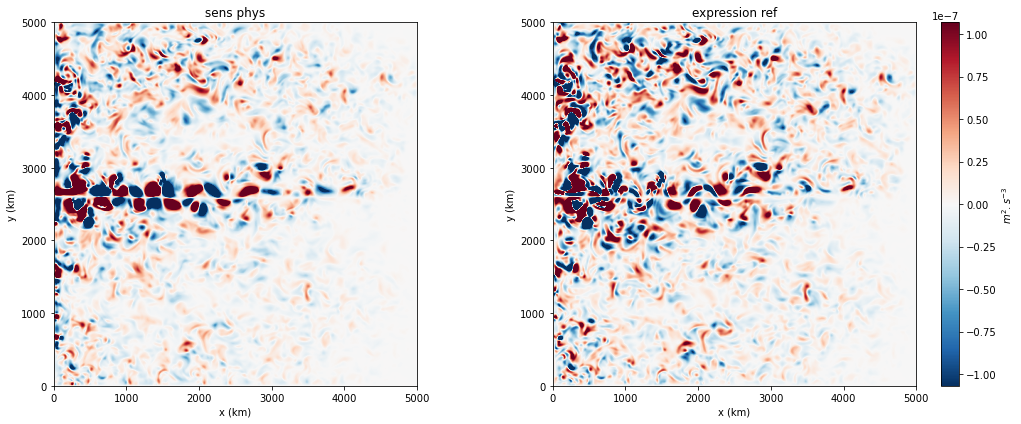

In [27]:
#plots ... doesn't make much sense to compare those

mpe2epe_i = -integral_z(mpe2epe, dh, Delta, Ht)
rec_pe_i = -integral_z(rec_pe,dh,Delta,Ht_b)


maxi = max(np.max(mpe2epe_i),np.abs(np.min(mpe2epe_i)))


fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize = (15,6),tight_layout=True)


col = ax1.imshow(mpe2epe_i, extent= [0,5000,0,5000], cmap='RdBu_r', vmax = maxi/20, vmin = -maxi/20)
ax1.set_aspect('equal')
ax1.set_title(' sens phys ')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')


col2 = ax2.imshow(rec_pe_i, extent= [0,5000,0,5000], cmap='RdBu_r', vmax = maxi/20, vmin = -maxi/20)
ax2.set_aspect('equal')
ax2.set_title('expression ref')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')


#cax = plt.axes([1, 0.05, 0.035, 0.9])

m2 = plt.cm.ScalarMappable(cmap='RdBu_r')
m2.set_array(mpe2epe_i)
m2.set_clim(-maxi/20, maxi/20)
plt.colorbar(m2,ax=ax2).set_label(r'$m^2.s^{-3}$')